In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [4]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [5]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|█████████████| 9912422/9912422 [00:00<00:00, 15719366.10it/s]


Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|█████████████████| 28881/28881 [00:00<00:00, 10157277.70it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



100%|██████████████| 1648877/1648877 [00:00<00:00, 8823034.40it/s]


Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|███████████████████| 4542/4542 [00:00<00:00, 18126097.78it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [8]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [9]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [10]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [11]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [12]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [13]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [14]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [16]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:50,  2.34it/s]                                          


Epoch 1 of 100
Generator loss: 4.02964539, Discriminator loss: 0.36324700


118it [00:51,  2.28it/s]                                          


Epoch 2 of 100
Generator loss: 1.81803629, Discriminator loss: 0.65767855


118it [00:55,  2.13it/s]                                          


Epoch 3 of 100
Generator loss: 2.61803445, Discriminator loss: 0.44007598


118it [01:04,  1.84it/s]                                          


Epoch 4 of 100
Generator loss: 2.21123132, Discriminator loss: 0.50881674


118it [01:08,  1.72it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


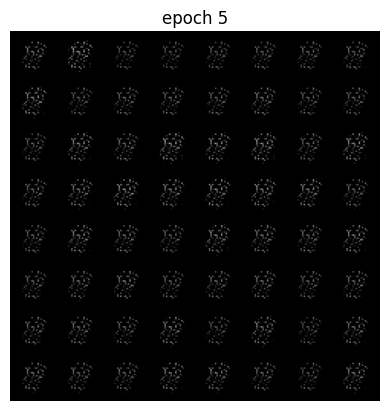

Epoch 5 of 100
Generator loss: 2.11090105, Discriminator loss: 0.62300427


118it [01:05,  1.81it/s]                                          


Epoch 6 of 100
Generator loss: 2.01706808, Discriminator loss: 0.48114498


118it [01:19,  1.49it/s]                                          


Epoch 7 of 100
Generator loss: 1.64651635, Discriminator loss: 0.62438036


118it [01:04,  1.83it/s]                                          


Epoch 8 of 100
Generator loss: 1.30982097, Discriminator loss: 0.49545818


118it [00:58,  2.03it/s]                                          


Epoch 9 of 100
Generator loss: 1.70712218, Discriminator loss: 0.46614007


118it [01:08,  1.72it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


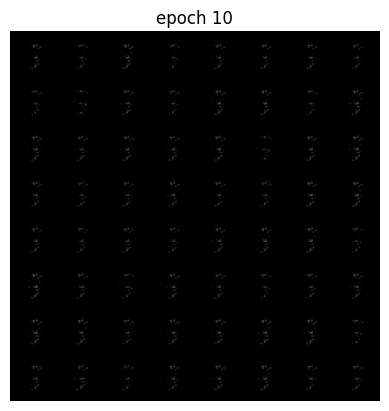

Epoch 10 of 100
Generator loss: 1.46751459, Discriminator loss: 0.51953248


118it [00:59,  1.98it/s]                                          


Epoch 11 of 100
Generator loss: 1.38753621, Discriminator loss: 0.50649138


118it [00:57,  2.06it/s]                                          


Epoch 12 of 100
Generator loss: 2.07973382, Discriminator loss: 0.36640981


118it [00:51,  2.29it/s]                                          


Epoch 13 of 100
Generator loss: 2.74088639, Discriminator loss: 0.38386458


118it [00:51,  2.31it/s]                                          


Epoch 14 of 100
Generator loss: 2.73377406, Discriminator loss: 0.34700211


118it [00:59,  1.98it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


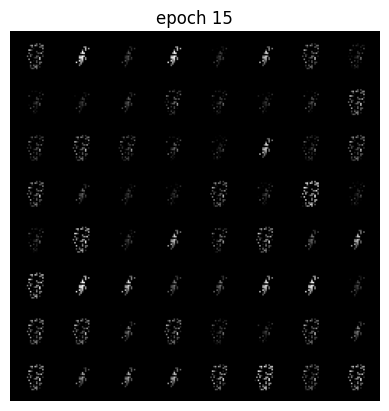

Epoch 15 of 100
Generator loss: 2.69969952, Discriminator loss: 0.33145276


118it [00:59,  1.99it/s]                                          


Epoch 16 of 100
Generator loss: 2.48486590, Discriminator loss: 0.30731676


118it [00:57,  2.07it/s]                                          


Epoch 17 of 100
Generator loss: 2.97804315, Discriminator loss: 0.30145646


118it [00:53,  2.20it/s]                                          


Epoch 18 of 100
Generator loss: 3.33045984, Discriminator loss: 0.24656449


118it [00:57,  2.06it/s]                                          


Epoch 19 of 100
Generator loss: 3.20683996, Discriminator loss: 0.16995222


118it [00:52,  2.26it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


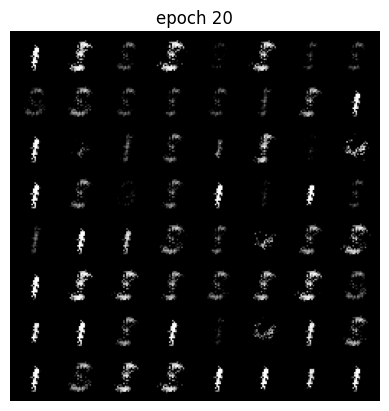

Epoch 20 of 100
Generator loss: 3.39312017, Discriminator loss: 0.25572396


118it [00:59,  1.99it/s]                                          


Epoch 21 of 100
Generator loss: 2.64311343, Discriminator loss: 0.31545163


118it [01:10,  1.67it/s]                                          


Epoch 22 of 100
Generator loss: 3.09599173, Discriminator loss: 0.19498338


118it [00:59,  1.97it/s]                                          


Epoch 23 of 100
Generator loss: 2.75358636, Discriminator loss: 0.29474884


118it [00:52,  2.25it/s]                                          


Epoch 24 of 100
Generator loss: 2.98086314, Discriminator loss: 0.20429258


118it [00:49,  2.37it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


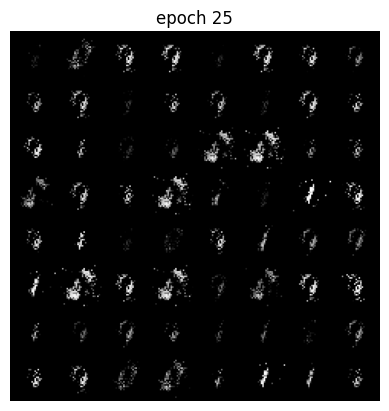

Epoch 25 of 100
Generator loss: 3.43885228, Discriminator loss: 0.26875560


118it [00:49,  2.41it/s]                                          


Epoch 26 of 100
Generator loss: 2.59914781, Discriminator loss: 0.32542362


118it [00:50,  2.35it/s]                                          


Epoch 27 of 100
Generator loss: 3.04022474, Discriminator loss: 0.28052932


118it [00:49,  2.39it/s]                                          


Epoch 28 of 100
Generator loss: 3.09069813, Discriminator loss: 0.28004390


118it [00:51,  2.27it/s]                                          


Epoch 29 of 100
Generator loss: 2.79481221, Discriminator loss: 0.31677387


118it [00:57,  2.04it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


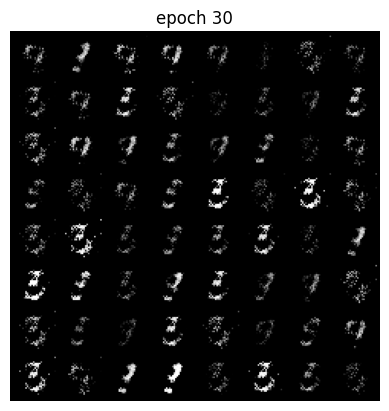

Epoch 30 of 100
Generator loss: 3.27636514, Discriminator loss: 0.22184087


118it [01:04,  1.83it/s]                                          


Epoch 31 of 100
Generator loss: 3.16199050, Discriminator loss: 0.23024991


118it [00:56,  2.09it/s]                                          


Epoch 32 of 100
Generator loss: 3.41325369, Discriminator loss: 0.25099583


118it [00:56,  2.10it/s]                                          


Epoch 33 of 100
Generator loss: 2.82270983, Discriminator loss: 0.28488858


118it [00:56,  2.11it/s]                                          


Epoch 34 of 100
Generator loss: 3.12031611, Discriminator loss: 0.23605890


118it [00:55,  2.13it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


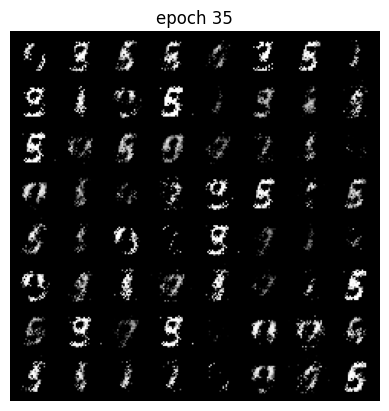

Epoch 35 of 100
Generator loss: 3.38707995, Discriminator loss: 0.19656526


118it [00:53,  2.20it/s]                                          


Epoch 36 of 100
Generator loss: 3.49084165, Discriminator loss: 0.21823625


118it [00:50,  2.35it/s]                                          


Epoch 37 of 100
Generator loss: 3.03109848, Discriminator loss: 0.29818366


118it [00:49,  2.40it/s]                                          


Epoch 38 of 100
Generator loss: 3.04435480, Discriminator loss: 0.24337708


118it [00:49,  2.39it/s]                                          


Epoch 39 of 100
Generator loss: 3.28965876, Discriminator loss: 0.22665421


118it [00:49,  2.37it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


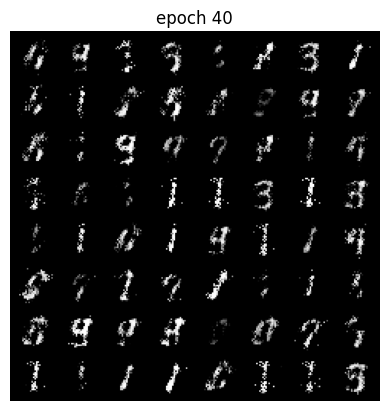

Epoch 40 of 100
Generator loss: 3.49876645, Discriminator loss: 0.23068902


118it [00:48,  2.44it/s]                                          


Epoch 41 of 100
Generator loss: 3.36376176, Discriminator loss: 0.18749338


118it [00:52,  2.25it/s]                                          


Epoch 42 of 100
Generator loss: 3.44692092, Discriminator loss: 0.22399132


118it [00:49,  2.39it/s]                                          


Epoch 43 of 100
Generator loss: 3.04649288, Discriminator loss: 0.26281206


118it [00:49,  2.41it/s]                                          


Epoch 44 of 100
Generator loss: 3.45424758, Discriminator loss: 0.21679159


118it [00:49,  2.39it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


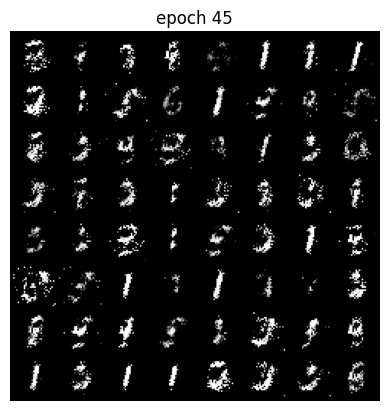

Epoch 45 of 100
Generator loss: 3.79654048, Discriminator loss: 0.17300970


118it [00:45,  2.61it/s]                                          


Epoch 46 of 100
Generator loss: 3.53319989, Discriminator loss: 0.27644493


118it [00:45,  2.60it/s]                                          


Epoch 47 of 100
Generator loss: 3.16467940, Discriminator loss: 0.22921450


118it [00:45,  2.62it/s]                                          


Epoch 48 of 100
Generator loss: 3.21931473, Discriminator loss: 0.25287544


118it [00:44,  2.67it/s]                                          


Epoch 49 of 100
Generator loss: 3.12605733, Discriminator loss: 0.25144221


118it [00:45,  2.60it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


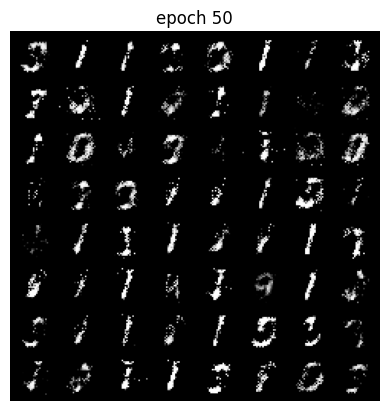

Epoch 50 of 100
Generator loss: 3.33368028, Discriminator loss: 0.22919333


118it [00:51,  2.28it/s]                                          


Epoch 51 of 100
Generator loss: 3.37433441, Discriminator loss: 0.22469357


118it [01:07,  1.74it/s]                                          


Epoch 52 of 100
Generator loss: 3.16467259, Discriminator loss: 0.24575216


118it [01:11,  1.65it/s]                                          


Epoch 53 of 100
Generator loss: 2.97493568, Discriminator loss: 0.26744879


118it [00:55,  2.11it/s]                                          


Epoch 54 of 100
Generator loss: 3.32520820, Discriminator loss: 0.24105917


118it [00:56,  2.11it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


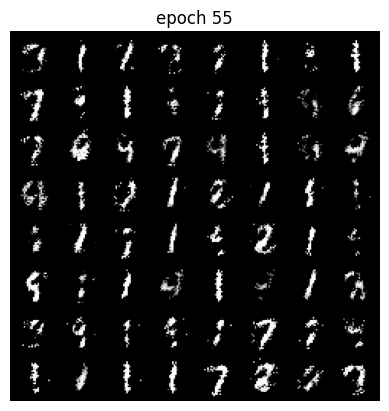

Epoch 55 of 100
Generator loss: 3.03553711, Discriminator loss: 0.24372010


118it [00:52,  2.25it/s]                                          


Epoch 56 of 100
Generator loss: 2.99919992, Discriminator loss: 0.25501609


118it [00:48,  2.44it/s]                                          


Epoch 57 of 100
Generator loss: 3.15506412, Discriminator loss: 0.23036522


118it [00:45,  2.60it/s]                                          


Epoch 58 of 100
Generator loss: 3.16739874, Discriminator loss: 0.24636128


118it [00:49,  2.38it/s]                                          


Epoch 59 of 100
Generator loss: 3.06736719, Discriminator loss: 0.24409290


118it [00:47,  2.48it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


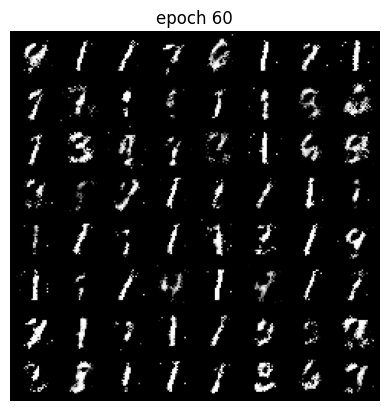

Epoch 60 of 100
Generator loss: 2.87277017, Discriminator loss: 0.25340811


118it [00:45,  2.59it/s]                                          


Epoch 61 of 100
Generator loss: 2.78863365, Discriminator loss: 0.27936990


118it [00:44,  2.68it/s]                                          


Epoch 62 of 100
Generator loss: 2.94988458, Discriminator loss: 0.27332406


118it [00:46,  2.56it/s]                                          


Epoch 63 of 100
Generator loss: 2.83061679, Discriminator loss: 0.28324517


118it [00:44,  2.64it/s]                                          


Epoch 64 of 100
Generator loss: 2.75740958, Discriminator loss: 0.30594678


118it [00:46,  2.53it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


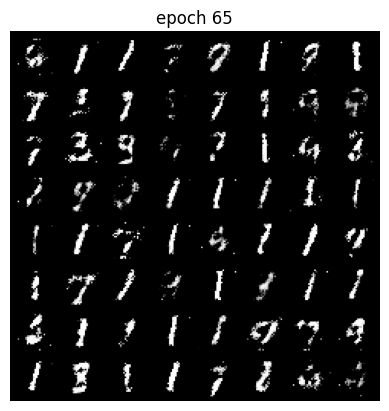

Epoch 65 of 100
Generator loss: 2.51867880, Discriminator loss: 0.29043730


118it [00:55,  2.13it/s]                                          


Epoch 66 of 100
Generator loss: 2.56507363, Discriminator loss: 0.29803933


118it [00:50,  2.36it/s]                                          


Epoch 67 of 100
Generator loss: 2.63870555, Discriminator loss: 0.27877263


118it [00:48,  2.45it/s]                                          


Epoch 68 of 100
Generator loss: 2.65798849, Discriminator loss: 0.28860541


118it [00:45,  2.60it/s]                                          


Epoch 69 of 100
Generator loss: 2.63571746, Discriminator loss: 0.30360976


118it [00:45,  2.62it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


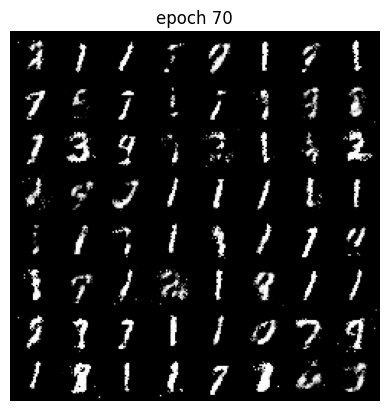

Epoch 70 of 100
Generator loss: 2.76858125, Discriminator loss: 0.28144334


118it [00:44,  2.63it/s]                                          


Epoch 71 of 100
Generator loss: 2.62531404, Discriminator loss: 0.29294069


118it [00:48,  2.43it/s]                                          


Epoch 72 of 100
Generator loss: 2.65325014, Discriminator loss: 0.29041953


118it [00:44,  2.64it/s]                                          


Epoch 73 of 100
Generator loss: 2.45054245, Discriminator loss: 0.30688575


118it [00:45,  2.60it/s]                                          


Epoch 74 of 100
Generator loss: 2.43608926, Discriminator loss: 0.30669883


118it [00:44,  2.67it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


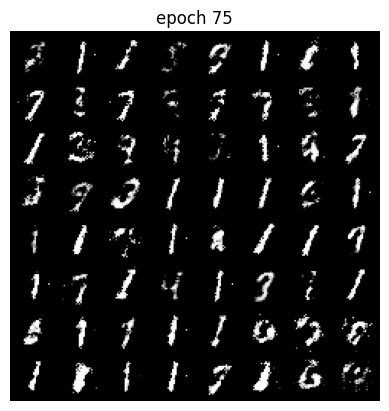

Epoch 75 of 100
Generator loss: 2.53072622, Discriminator loss: 0.29845073


118it [00:44,  2.64it/s]                                          


Epoch 76 of 100
Generator loss: 2.57023732, Discriminator loss: 0.29950486


118it [00:44,  2.68it/s]                                          


Epoch 77 of 100
Generator loss: 2.56147967, Discriminator loss: 0.30405052


118it [00:47,  2.49it/s]                                          


Epoch 78 of 100
Generator loss: 2.36769267, Discriminator loss: 0.32856826


118it [00:46,  2.53it/s]                                          


Epoch 79 of 100
Generator loss: 2.42782102, Discriminator loss: 0.32435509


118it [00:46,  2.52it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


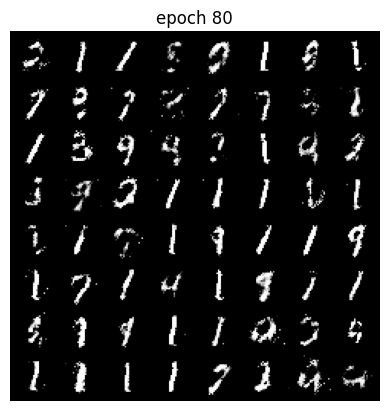

Epoch 80 of 100
Generator loss: 2.40044162, Discriminator loss: 0.32046309


118it [00:44,  2.68it/s]                                          


Epoch 81 of 100
Generator loss: 2.33437420, Discriminator loss: 0.33155069


118it [00:44,  2.67it/s]                                          


Epoch 82 of 100
Generator loss: 2.40435244, Discriminator loss: 0.33326313


118it [00:43,  2.69it/s]                                          


Epoch 83 of 100
Generator loss: 2.16459822, Discriminator loss: 0.35123641


118it [00:44,  2.68it/s]                                          


Epoch 84 of 100
Generator loss: 2.24442953, Discriminator loss: 0.33958592


118it [00:45,  2.62it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


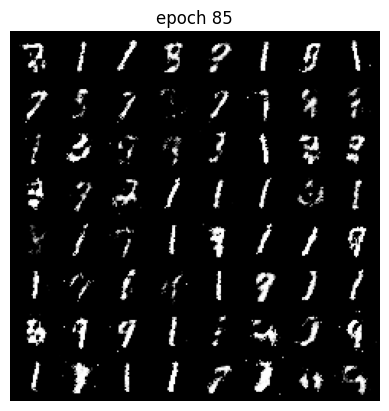

Epoch 85 of 100
Generator loss: 2.25050933, Discriminator loss: 0.34020010


118it [00:45,  2.59it/s]                                          


Epoch 86 of 100
Generator loss: 2.17033921, Discriminator loss: 0.34768251


118it [00:45,  2.61it/s]                                          


Epoch 87 of 100
Generator loss: 2.19150324, Discriminator loss: 0.35866534


118it [00:45,  2.61it/s]                                          


Epoch 88 of 100
Generator loss: 2.10194599, Discriminator loss: 0.35902112


118it [00:44,  2.63it/s]                                          


Epoch 89 of 100
Generator loss: 2.26772897, Discriminator loss: 0.34289980


118it [00:44,  2.65it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


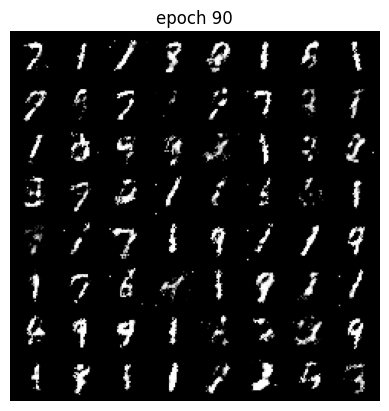

Epoch 90 of 100
Generator loss: 2.19081706, Discriminator loss: 0.35334510


118it [00:44,  2.64it/s]                                          


Epoch 91 of 100
Generator loss: 2.22013811, Discriminator loss: 0.35685734


118it [00:43,  2.69it/s]                                          


Epoch 92 of 100
Generator loss: 2.07154227, Discriminator loss: 0.36822945


118it [00:45,  2.62it/s]                                          


Epoch 93 of 100
Generator loss: 2.18906551, Discriminator loss: 0.34949371


118it [00:44,  2.62it/s]                                          


Epoch 94 of 100
Generator loss: 2.02714346, Discriminator loss: 0.38901274


118it [00:44,  2.66it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


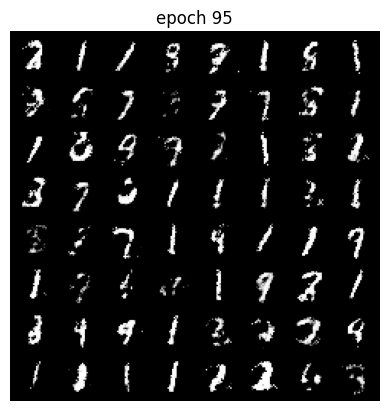

Epoch 95 of 100
Generator loss: 2.10682840, Discriminator loss: 0.37472511


118it [00:44,  2.63it/s]                                          


Epoch 96 of 100
Generator loss: 2.11352983, Discriminator loss: 0.35675512


118it [00:44,  2.68it/s]                                          


Epoch 97 of 100
Generator loss: 2.04749411, Discriminator loss: 0.37207889


118it [00:44,  2.67it/s]                                          


Epoch 98 of 100
Generator loss: 2.03687169, Discriminator loss: 0.37348414


118it [00:44,  2.63it/s]                                          


Epoch 99 of 100
Generator loss: 2.01573972, Discriminator loss: 0.39083450


118it [00:44,  2.65it/s]                                          
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


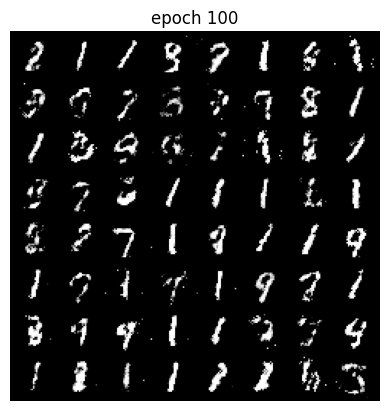

Epoch 100 of 100
Generator loss: 2.08319703, Discriminator loss: 0.39165816


In [44]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return criterion(output, true_label)
    
    
    ######################################
    
def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    #print(output.shape)
    return criterion(output, true_label)
    
    
    ######################################
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 

        
        # ###  Training discriminator ####
        # 1. Generate fake data
        real_batch_size = data[0].shape[0]
        noisy_input = create_noise(real_batch_size, nz)
        fake_samples = generator(noisy_input)
        fake_labels = torch.zeros(real_batch_size)
        # print(fake_samples.shape)
        # print(fake_labels.shape)
        real_samples = data[0]
        real_labels = torch.zeros(real_batch_size) + 1
        # print(real_samples.shape)
        # print(real_labels)
        combined_samples = torch.cat((real_samples,fake_samples),0)
        combined_labels = torch.cat((real_labels,fake_labels),0).view(real_batch_size*2, 1)
        # 2. Forward and backward
        optim_d.zero_grad()
        dis_output = discriminator(combined_samples)
        loss_D = discriminator_loss(dis_output, combined_labels)
        loss_D.backward()
        loss_d += loss_D.item()
        optim_d.step()

        # Training generator
        # 1. Generate fake data
        noisy_input2 = create_noise(real_batch_size, nz)
        fake_labels2 = (torch.zeros(real_batch_size) + 1).view(real_batch_size, 1) #We want them to be true
        # 2. Frward and backward
        optim_g.zero_grad()
        dis_output2 = discriminator(generator(noisy_input2))
        loss_G = generator_loss(dis_output2, fake_labels2)
        loss_G.backward()
        loss_g += loss_G.item()
        optim_g.step()

    
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [17]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [45]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

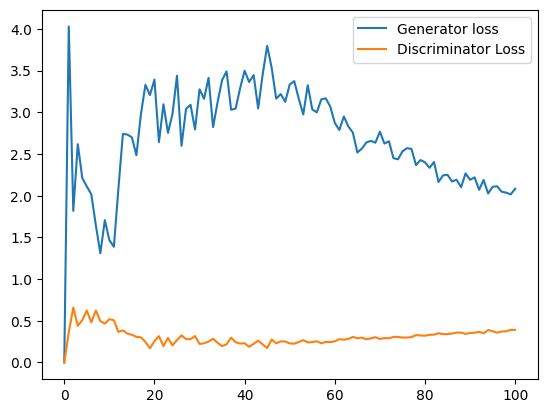

In [46]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')